# Bayesian A/B Testing Example

Simple implementation in Python. Nevertheless, if we have proportions like CVR, we can use Bayesian calculators as [this one](https://making.lyst.com/bayesian-calculator/) or [this one](https://marketing.dynamicyield.com/bayesian-calculator/?_ga=2.260149455.37594591.1604322357-1946895922.1603916593) for multiple variants.

Older implementation of this notebooks could be found in [Bayesian Colab Notebook](https://colab.research.google.com/drive/15eM1F6CIrT1f_BCj2NlCrJjCMViTMP0s#scrollTo=BNEv85KpGWWc)


## Importing Packages

The following block has older instalations of the packages that we are going to use

In [1]:
# pymc3 has been already installed in colab but it has a problem with Arviz package
#!pip install pymc3==3.9
#!pip install pymc3[plots] -q
#!pip install arviz==0.8.3

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import beta, bernoulli
from statsmodels.stats.proportion import proportions_ztest
#import pymc3 as pm
import pymc as pm
sns.set_style('whitegrid')

## Setting Parameters

In [5]:
# Real CVR values (unknown)
P_A = 0.20 # we don't know it in a real experiment
P_B = 0.205 # we don't know it in a real experiment

# Parameters for our priors

# Beta function: if alpha=1 and beta=1 then this is exactly as un uniform(0,1)
# this is an uninformative prior
ALPHA_PRIOR = 1
BETA_PRIOR = 1

NUMBER_SESSIONS = 20000 # Per Variant


POSTERIOR_SAMPLE_SIZE = 10000 # Sample from posterior distribution
BURNED_SIZE = 1000 # number of posterior samples that we discard
NUMBER_PER_DAY = 500 # We suppose that we have 500 sessions per day
RESOLUTION = 10000

TOC = 0.0005 # Threshold of caring (20% * 0.25% = 0.05%)

"""
Since the expected loss for a variant is the average amount by which our metric
would decrease if we chose that variant, we should set ε to be so small that
we are comfortable making a mistake of that magnitude. The idea is that we would
rather make a mistake of magnitude ε and then move onto a more promising
experiment than spend too much time on the first experiment.

The interpretation of ε or TOC is as follows - ε is a percentage. It represents how
much lift one would expect to lose by making a particular choice given that the
choice is wrong. It should be set to a number so low that one does not care if
an error is made by this amount

Example Suppose we are testing two button colors, and we are interested
in measuring lift of 10%. Conversely, if the lift we get from this test changes
negatively by 0.2% or less, this change is so small that we don’t care. In that
case, we can choose ε = 0.0002.
"""

'\nSince the expected loss for a variant is the average amount by which our metric\nwould decrease if we chose that variant, we should set ε to be so small that\nwe are comfortable making a mistake of that magnitude. The idea is that we would\nrather make a mistake of magnitude ε and then move onto a more promising\nexperiment than spend too much time on the first experiment.\n\nThe interpretation of ε or TOC is as follows - ε is a percentage. It represents how\nmuch lift one would expect to lose by making a particular choice given that the\nchoice is wrong. It should be set to a number so low that one does not care if\nan error is made by this amount\n\nExample Suppose we are testing two button colors, and we are interested\nin measuring lift of 10%. Conversely, if the lift we get from this test changes\nnegatively by 0.2% or less, this change is so small that we don’t care. In that\ncase, we can choose ε = 0.0002.\n'

## Simulation of sessions groups

In [6]:
p_a = bernoulli.rvs(p=0.20, size=10)
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

sessions_a = bernoulli.rvs(p=P_A, size=NUMBER_SESSIONS)
sessions_b = bernoulli.rvs(p=P_B, size=NUMBER_SESSIONS)

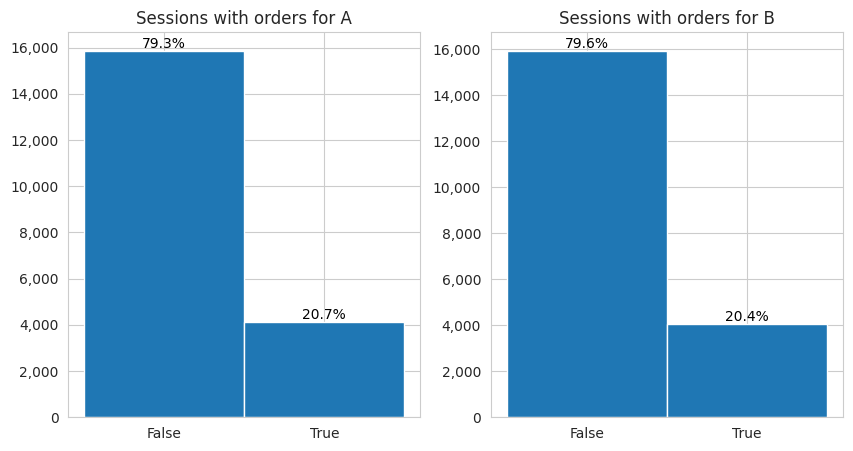

In [7]:
# Plot to see that everything is ok
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

plt.hist(sessions_a, bins = 2)
plt.title("Sessions with orders for A")
plt.xticks((0.25,0.75), (False, True))
#plt.ylim(0, 1600)
plt.gca().yaxis.set_major_formatter(
    StrMethodFormatter('{x:,.0f}'))  # No decimal places
total = len(sessions_a)
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{:.1%}'.format(float(p.get_height()/total)),
            fontsize=10, color='black', ha='center', va='bottom')

plt.subplot(1, 2, 2)

plt.hist(sessions_b, bins = 2)
plt.title("Sessions with orders for B")
plt.xticks((0.25,0.75), (False, True))
#plt.ylim(0, 1600)
plt.gca().yaxis.set_major_formatter(
    StrMethodFormatter('{x:,.0f}'))  # No decimal places
total = len(sessions_b)
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{:.1%}'.format(float(p.get_height()/total)),
            fontsize=10, color='black', ha='center', va='bottom')

plt.show()


## Calculate p-value Z-test Proportions



https://www.evanmiller.org/ab-testing/sample-size.html

Using :

Baseline Conversion Rate: 20%

Minimum Detectable Effect: 0.5% Absolute

Statistical power 1−β: 90%

Significance level α:	5%

<b> Sample size per variation: 134,989 </b>

In [8]:
# Calculate p-value Z-test proportions

# https://www.evanmiller.org/ab-testing/sample-size.html
# Using : Baseline Conversion Rate: 20%
# Minimum Detectable Effect: 0.5% Absolute
# Statistical power 1−β: 90%
# Significance level α:	5%
# Sample size per variation: 134,989

print("Z-test proportion", end='\n\n')
# count = np.array([sessions_a[sessions_a == 1].sum(), sessions_b[sessions_b == 1].sum()])
# nobs = np.array([len(sessions_a), len(sessions_b)])

count = [489, 1220]
nobs = [2075, 4956]
#  One-sided tests
stat, pval = proportions_ztest(count, nobs, alternative="smaller")
print("p-value one sided: ", '{0:0.3f}'.format(pval))

if pval < 0.05:
    print( "Null Hypothesis is rejected", end='\n\n')
else:
    print( "We cannot reject Null Hypothesis", end='\n\n' )

#  Two-sided tests
stat, pval = proportions_ztest(count, nobs)
print("p-value two sided: ", '{0:0.3f}'.format(pval))

if pval < 0.05:
    print( "Null Hypothesis is rejected")
else:
    print( "We cannot reject Null Hypothesis", end='\n\n' )

Z-test proportion

p-value one sided:  0.175
We cannot reject Null Hypothesis

p-value two sided:  0.349
We cannot reject Null Hypothesis



## Calculate Posterior Distribution

We have a conjugate prior!. We know the closed-form expression of posteriori distribution

Mean of Posterior A:  0.2066
Mean of Posterior B:  0.2036

Probability that B is better than A is:  0.2262
Probability that B is better than A at least 0.1% is:  0.1581
Probability that B is better than A at least 0.2% is:  0.1022
Probability that B is better than A at least 0.3% is:  0.0635
Probability that B is better than A at least 0.5% is:  0.0213

90% Credible Interval for A:  0.2020 - 0.2113
90% Credible Interval for B:  0.1989 - 0.2083

95% Credible Interval for A:  0.2010 - 0.2122
95% Credible Interval for B:  0.1981 - 0.2092


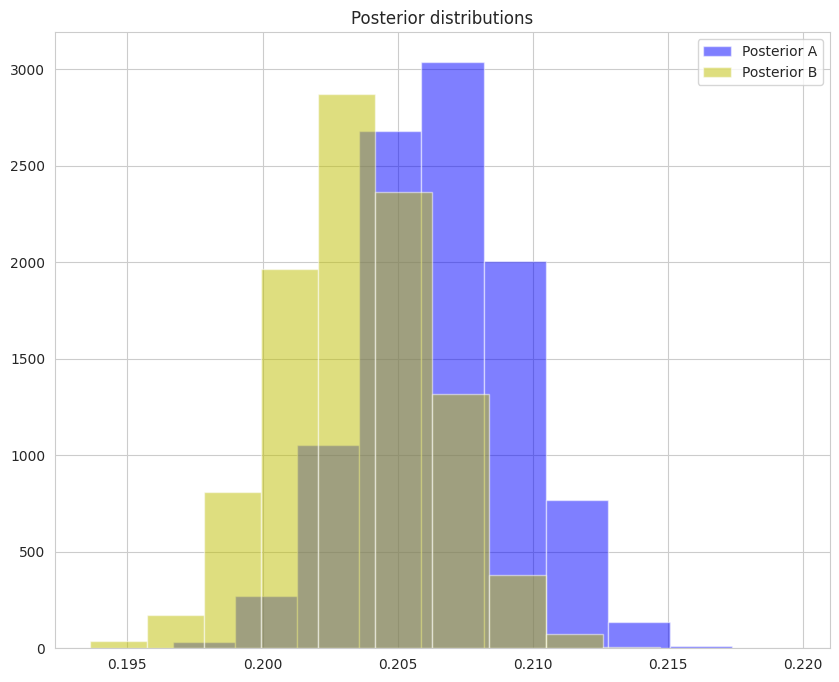

In [9]:
# Calculate Posterior Distribution with conjugate prior

posterior_A = beta(ALPHA_PRIOR + np.sum(sessions_a),
                    BETA_PRIOR + len(sessions_a[sessions_a == 0])
                  )

posterior_B = beta(ALPHA_PRIOR + np.sum(sessions_b),
                    BETA_PRIOR + len(sessions_b[sessions_b == 0])
                  )


# posterior_A = beta(ALPHA_PRIOR + 82662,
#                     BETA_PRIOR + 262717 - 82662)


# posterior_B = beta(ALPHA_PRIOR + 82870,
#                     BETA_PRIOR + 260867 - 82870)



samples_posterior_A = posterior_A.rvs(POSTERIOR_SAMPLE_SIZE)
samples_posterior_B = posterior_B.rvs(POSTERIOR_SAMPLE_SIZE)


print("Mean of Posterior A: ", round((samples_posterior_A).mean(),4) )
print("Mean of Posterior B: ", round((samples_posterior_B).mean(),4) )
print()

print("Probability that B is better than A is: ", (samples_posterior_B > samples_posterior_A).mean() )
print("Probability that B is better than A at least 0.1% is: ", (samples_posterior_B > samples_posterior_A + 0.001).mean() )
print("Probability that B is better than A at least 0.2% is: ", (samples_posterior_B > samples_posterior_A + 0.002).mean() )
print("Probability that B is better than A at least 0.3% is: ", (samples_posterior_B > samples_posterior_A + 0.003).mean() )
print("Probability that B is better than A at least 0.5% is: ", (samples_posterior_B > samples_posterior_A + 0.005).mean() )

a_25 = np.percentile(samples_posterior_A, 2.5)
a_5 = np.percentile(samples_posterior_A, 5)
a_95 = np.percentile(samples_posterior_A, 95)
a_975 = np.percentile(samples_posterior_A, 97.5)

b_25 = np.percentile(samples_posterior_B, 2.5)
b_5 = np.percentile(samples_posterior_B, 5)
b_95 = np.percentile(samples_posterior_B, 95)
b_975 = np.percentile(samples_posterior_B, 97.5)

print()
print("90% Credible Interval for A: ","{:.4f} - {:.4f}".format(a_5, a_95))
print("90% Credible Interval for B: ","{:.4f} - {:.4f}".format(b_5, b_95))
print()
print("95% Credible Interval for A: ","{:.4f} - {:.4f}".format(a_25, a_975))
print("95% Credible Interval for B: ","{:.4f} - {:.4f}".format(b_25, b_975))


plt.figure(figsize=(10,8))
plt.hist(samples_posterior_A, alpha=0.5, color='b', label="Posterior A")
plt.hist(samples_posterior_B, alpha=0.5, color='y', label="Posterior B")
plt.legend()
plt.title("Posterior distributions")
plt.show()




We can check if PyMC3 estimates posterior distribution correctly

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_B, p_A]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 76 seconds.


Mean of Posterior A:  0.1998
Mean of Posterior B:  0.2047
Probability that B is better than A is:  0.8869


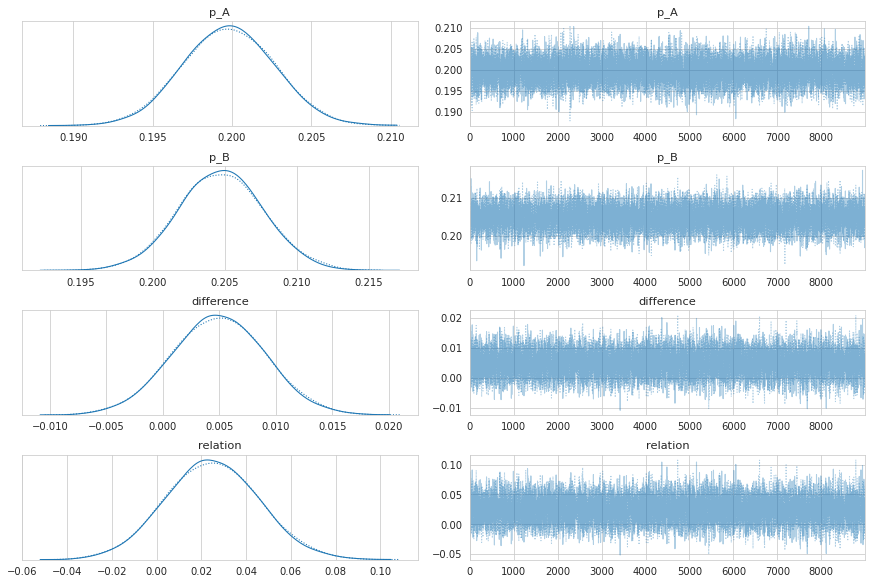

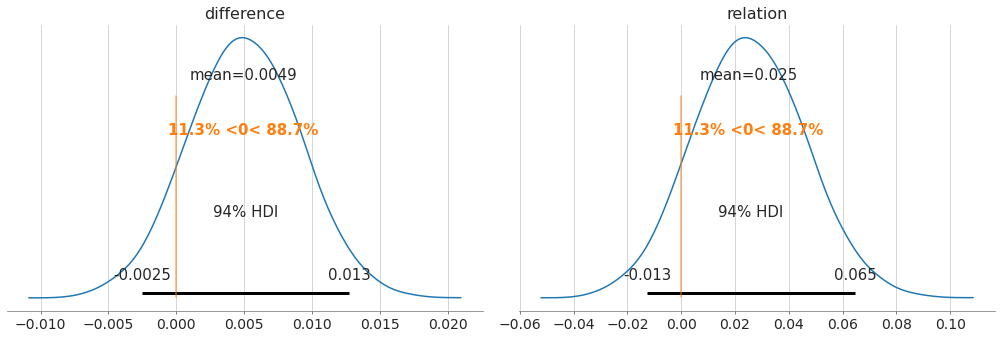

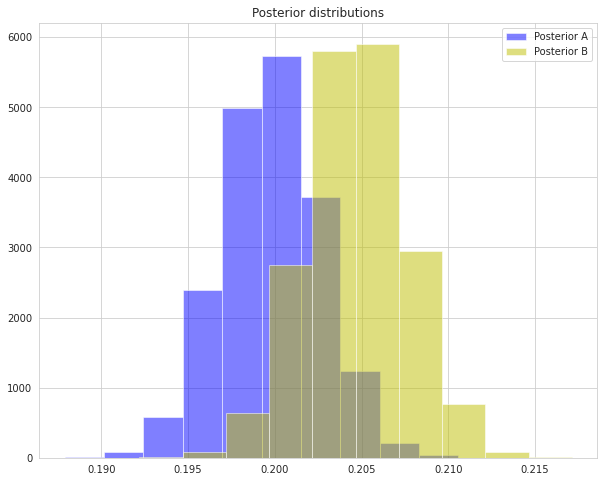

In [ ]:
# Calculate Posterior Distribution with MCMC
with pm.Model() as model:

    # define priors
    p_A = pm.distributions.continuous.Beta('p_A', alpha=ALPHA_PRIOR, beta=BETA_PRIOR)
    p_B = pm.distributions.continuous.Beta('p_B', alpha=ALPHA_PRIOR, beta=BETA_PRIOR)

    # define likelihood
    obs_A = pm.Bernoulli('obs_A', p=p_A, observed=sessions_a)
    obs_B = pm.Bernoulli('obs_B', p=p_B, observed=sessions_b)

    # define metrics
    pm.Deterministic('difference', p_B - p_A)
    pm.Deterministic('relation', (p_B / p_A) - 1)

    # PyMC3 has a bug in Windows. We can use only 1 core
    trace = pm.sample(POSTERIOR_SAMPLE_SIZE, cores=1)

print("Mean of Posterior A: ", round((trace["p_A"][BURNED_SIZE:]).mean(),4) )
print("Mean of Posterior B: ", round((trace["p_B"][BURNED_SIZE:]).mean(),4) )
print("Probability that B is better than A is: ",round((trace["difference"][BURNED_SIZE:] > 0).mean(), 4) )

# PyMC Checks
pm.traceplot(trace[BURNED_SIZE:])
plt.show()

# Plot Posterior Distributions
pm.plot_posterior(trace, ref_val=0, var_names=["difference", "relation"]) # Centered at 0

#pm.plot_posterior(trace)

plt.show()

plt.figure(figsize=(10,8))
plt.hist(trace["p_A"][BURNED_SIZE:], alpha=0.5, color='b', label="Posterior A")
plt.hist(trace["p_B"][BURNED_SIZE:], alpha=0.5, color='y', label="Posterior B")
plt.legend()
plt.title("Posterior distributions")
plt.show()

## Expected Loss

Finally, we need to know when to stop the experiment (we don't calculate a sample size).

There are a couple of possibilities, but we chose Expected Loss.

 The A/B test is running until the expected loss is below this specified tolerance (TOC)

 https://cdn2.hubspot.net/hubfs/310840/VWO_SmartStats_technical_whitepaper.pdf

This function is part of abyes package (with some modifications)

https://github.com/cbellei/abyes/blob/master/abyes/ab_exp.py

In [ ]:
def expected_loss_decision(alpha_prior, beta_prior, sessions_a, sessions_b, toc = 0.001, resolution=500, print_result=True):
    """
    Calculate expected loss and apply decision rule
    """

    x = np.linspace(0, 1, resolution-1)
    dx = x[1] - x[0]
    pa = (np.array([beta.pdf(xx, alpha_prior + np.sum(sessions_a), beta_prior + len(sessions_a[sessions_a == 0])) for xx in x]), np.append(x, x[-1]+dx) - 0.5*dx)
    pb = (np.array([beta.pdf(xx, alpha_prior + np.sum(sessions_b), beta_prior + len(sessions_b[sessions_b == 0])) for xx in x]), np.append(x, x[-1] + dx) - 0.5 * dx)

    # bootstrapping now
    a_rvs = beta.rvs(alpha_prior + np.sum(sessions_a), beta_prior + len(sessions_a[sessions_a == 0]), size=400 * resolution)
    b_rvs = beta.rvs(alpha_prior + np.sum(sessions_b), beta_prior + len(sessions_b[sessions_b == 0]), size=400 * resolution)

    rvs = b_rvs - a_rvs

    bins = np.linspace(np.min(rvs) - 0.2 * abs(np.min(rvs)), np.max(rvs) + 0.2 * abs(np.max(rvs)), resolution)

    lift = np.histogram(rvs, bins=bins, density=True)

    dl = lift[1]
    dl = 0.5 * (dl[0:-1] + dl[1:])
    fdl = lift[0]
    inta = np.maximum(dl, 0) * fdl
    intb = np.maximum(-dl, 0) * fdl

    ela = np.trapz(inta, dl)
    elb = np.trapz(intb, dl)

    if ela <= toc and elb <= toc:
        result = 0
    elif elb < toc:
        result = 1
    elif ela < toc:
        result = -1
    else:
        result = np.nan

    msg = ''
    if result == 1:
        msg = 'Result is conclusive: B variant is winner! \U0001F604'
    elif result == -1:
        msg = '* Result is conclusive: A variant is winner! \U0001F604'
    elif result == 0:
        msg = '* Result is conclusive: A and B variants are effectively equivalent! \U0001F604'
    else:
        if(type(result)==list and len(result)==2):
            print_result(result[0])
            print_result(result[1])
        else:
            msg = 'Result is inconclusive. \U0001F62D'
    if print_result:
        print(msg)

    return ela, elb

This function will tell us if the result is conclusive or not according to this threshold

In [ ]:
sessions_a = np.concatenate( [np.zeros(262717 - 82662), np.ones(82662)] )
sessions_b = np.concatenate( [np.zeros(260867 - 82870), np.ones(82870)] )

TOC = 0.00075 # Threshold of caring (30% * 0.25% = 0.075%)

result = expected_loss_decision(alpha_prior=ALPHA_PRIOR,
                                beta_prior=BETA_PRIOR,
                                sessions_a=sessions_a,
                                sessions_b=sessions_b,
                                toc=TOC,
                                resolution=RESOLUTION
                                )


Result is conclusive: B variant is winner! 😄


In [ ]:
# NUMBER_PER_DAY = 500

elas = np.zeros(len(range(0, NUMBER_SESSIONS, NUMBER_PER_DAY)) )
elbs = np.zeros(len(range(0, NUMBER_SESSIONS, NUMBER_PER_DAY)) )

for i, sessions_per_day in enumerate( range(0, NUMBER_SESSIONS, NUMBER_PER_DAY) ):

    result = expected_loss_decision(alpha_prior=ALPHA_PRIOR, beta_prior=BETA_PRIOR,
                                    sessions_a=sessions_a[:sessions_per_day],
                                    sessions_b=sessions_b[:sessions_per_day],
                                    toc=TOC, resolution=RESOLUTION,
                                    print_result=False)

    elas[i] = result[0]
    elbs[i] = result[1]

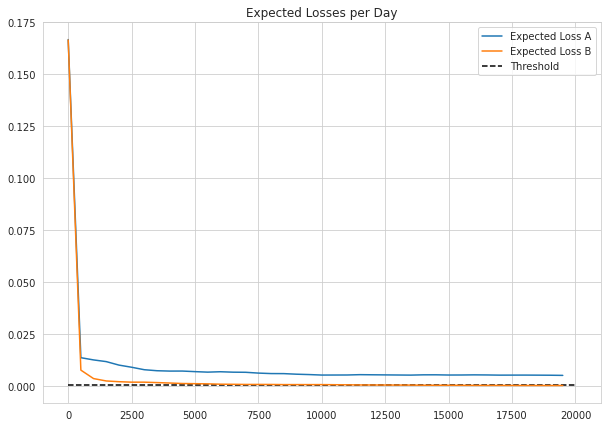

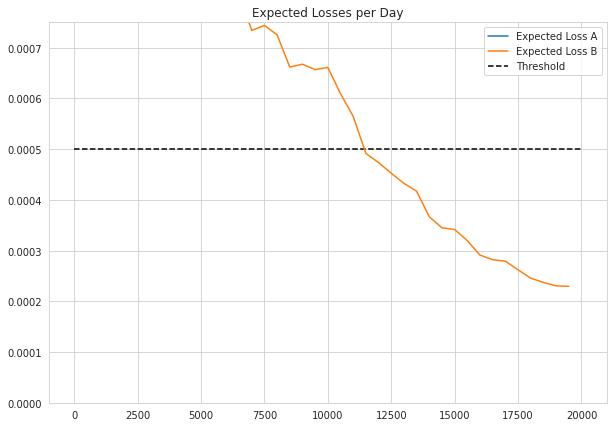

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(range(0, NUMBER_SESSIONS, NUMBER_PER_DAY), elas, label="Expected Loss A")
plt.plot(range(0, NUMBER_SESSIONS, NUMBER_PER_DAY), elbs, label="Expected Loss B")
plt.hlines(TOC, 0, NUMBER_SESSIONS, label="Threshold", linestyles="dashed")
plt.legend()
plt.title("Expected Losses per Day")
plt.show()


# Focused on threshold
plt.figure(figsize=(10,7))
plt.plot(range(0, NUMBER_SESSIONS, NUMBER_PER_DAY), elas, label="Expected Loss A")
plt.plot(range(0, NUMBER_SESSIONS, NUMBER_PER_DAY), elbs, label="Expected Loss B")
plt.hlines(TOC, 0, NUMBER_SESSIONS, label="Threshold", linestyles="dashed")
plt.legend()
plt.ylim(0, TOC*1.5)
plt.title("Expected Losses per Day")
plt.show()